In [1]:
import pandas as pd               # Pandas handles dataframes
import numpy as np                # Numpy handles lots of basic maths operations
import matplotlib.pyplot as plt   # Matplotlib for plotting
import seaborn as sns
pd.set_option('display.max_columns',100)


# Indicadores de engajamento
Neste notebook vamos tentar analisar como melhor criar "indicadores" de engajamento, a partir dos logs do Moodle ou "clickstream data" como é chamado em inglês. Um indicador possível, o mais simples, seria o número de clicks (alunos mais engajados, clicam mais). Mas vamos investigar também indicadores mais sofisticados, porque é bem possível que por exemplo o número de interações com questionários, ou número de envios (em Tarefa, ou Questionário), são indicadores melhores, no sentido de distinguir melhor entre alunos realmente engajados e alunos que meramente clicaram muito.

## Carregar os dados

In [2]:
logs = pd.read_csv('data/nonpublic/logs-4300459-2021.csv',parse_dates=['timecreated'])
del logs['ip']
logs[:3]

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
0,1656410674,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,57309,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-15 20:23:04,web,NaN
1,1654886276,\core\event\course_viewed,core,viewed,course,NaN,NaN,r,2,5498136,50,79580,12720,79580,NaN,0,"a:1:{s:19:""coursesectionnumber"";i:11;}",2021-02-02 14:03:13,web,NaN
2,1654886263,\mod_chat\event\course_module_viewed,mod_chat,viewed,course_module,chat,4973.0,r,2,5552661,70,3074106,12720,79580,NaN,0,N;,2021-02-02 14:03:08,web,NaN


## Filtrar e agregar por userid
O objetivo incial é conseguir um dataframe com uma linha por userid e com colunas com indicadores potenciais. Primeiro vamos filtrar os userid que não interessam (2 = gerente, 6 = ewout, -1 = visitante)

In [3]:
logs_f = logs.query("userid != 0 & userid != 2 & userid != 6 & userid != -1")

Agora vamos criar um Series com index = userid e valor = número de clicks (o indicador mais simples possível)

In [4]:
clicks_por_userid = logs_f.groupby('userid')['id'].count()
clicks_por_userid.sort_values(ascending=False)

userid
44980     1353
26462     1277
170110    1257
78746     1252
253119    1246
          ... 
57257        2
251813       1
6401         1
288579       1
307871       1
Name: id, Length: 64, dtype: int64

Um outro indicador possível é o número de engajamentos com os questionários. Vamos só ver como filtrar os logs para somente retornar clicks em Questionários

In [5]:
logs_f.query("component == 'mod_quiz'")[:5]

,id,eventname,component,action,target,objecttable,objectid,crud,edulevel,contextid,contextlevel,contextinstanceid,userid,courseid,relateduserid,anonymous,other,timecreated,origin,realuserid
1006,1641540995,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93089.0,r,2,5524821,70,3051907,172695,79580,NaN,0,N;,2020-12-12 22:41:46,ws,NaN
1007,1641540284,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93087.0,r,2,5524743,70,3051829,172695,79580,NaN,0,N;,2020-12-12 22:40:31,ws,NaN
1008,1641539653,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93086.0,r,2,5524731,70,3051817,172695,79580,NaN,0,N;,2020-12-12 22:39:38,ws,NaN
1338,1641499209,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93089.0,r,2,5524821,70,3051907,42046,79580,NaN,0,N;,2020-12-12 21:28:08,web,NaN
2001,1641110122,\mod_quiz\event\course_module_viewed,mod_quiz,viewed,course_module,quiz,93086.0,r,2,5524731,70,3051817,26335,79580,NaN,0,N;,2020-12-12 02:00:40,ws,NaN


Ah sim, só filtrar por 'mod_quiz"

In [6]:
quiz = logs_f.query("component == 'mod_quiz'")
quiz_por_userid = quiz.groupby('userid')['id'].count()
quiz_por_userid[:5]

userid
1170     75
2471     43
3021     90
3596    182
4928     46
Name: id, dtype: int64

Mas e se quero somente ver os envios de tentativa, não o total? A função value_counts() de um Series conta quantas vezes um valor aparece no Series:

In [7]:
quiz['action'].value_counts()

viewed       3551
reviewed      221
started       204
submitted     188
Name: action, dtype: int64

Então acho que um indicador interessante é o action = submitted, porque isso mede quantas vezes um aluno realmente submeteu uma tentativa, não somente quantas vezes entrou no Questionário (claro que estes 2 indicadores vão ser correlacionados). 

In [8]:
quiz_envio = quiz.query("action == 'submitted'")
quiz_envio_por_userid = quiz_envio.groupby('userid')['id'].count()
quiz_envio_por_userid[:5]

userid
1170    2
2471    1
3021    4
3596    6
4928    2
Name: id, dtype: int64

## Juntar num DataFrame
Agora temos 3 Series (clicks_por_userid, quiz_por_userid e quiz_envio_por_userid), com index = userid. Vamos user pd.concat parajuntar eles num dataframe. Este dataframe vai servir como resultado intermediário, que vamos analisar depois mais.

Note o axis = 1, se usar o padrão axis = 0 o pd.concat coloca os 3 Series um "acima" do outro. Não queremos isso, queremos 

In [9]:
indicadores = pd.concat([clicks_por_userid,quiz_por_userid,quiz_envio_por_userid],axis = 1)
indicadores

,id,id,id
userid,,,
1170,315,75.0,2.0
2471,194,43.0,1.0
3021,617,90.0,4.0
3596,1029,182.0,6.0
4928,139,46.0,2.0
...,...,...,...
276251,1100,89.0,5.0
288579,1,NaN,NaN
295092,3,NaN,NaN


Vemos que por exemplo o userid = 307871 ficou com NaN na 2a coluna (quiz_por_userid). Isso é porque este userid não tinha o dataframe após o filtro quiz = logs_f.query("component == 'mod_quiz'". Vamos substituir este NaN por 0, porque esse neste caso é a interpretação correta (zero clicks em quiz)

In [10]:
indicadores = indicadores.fillna(0)

In [11]:
# colocar nomes nas colunas
indicadores.columns = ['clicks','quiz_total','quiz_envios']
indicadores[:5]

,clicks,quiz_total,quiz_envios
userid,,,
1170,315,75.0,2.0
2471,194,43.0,1.0
3021,617,90.0,4.0
3596,1029,182.0,6.0
4928,139,46.0,2.0


Agora temos um dataframe com 3 colunas e indexados pelo userid. Podemos imaginar criar um 4o indicador, que é uma combinação linear dos primeiros três. Vamos pegar um exemplo ridículo, só para exemplificar o princípio.  

In [12]:
indicador4 = indicadores['clicks'] + 0.5*indicadores['quiz_total'] + 4*indicadores['quiz_envios']
indicador4

userid
1170       360.5
2471       219.5
3021       678.0
3596      1144.0
4928       170.0
           ...  
276251    1164.5
288579       1.0
295092       3.0
307871       1.0
307966     517.5
Length: 64, dtype: float64

## Normalização
Mas vamos e convenhamos, não faz sentido nenhum de somar o número de clicks total com número de clicks em quiz com número de envios de questionários. Estes indicadores tem "escalas" diferentes e não podem ser comparados ou combinados diretamente. Uma maneira de deixar vários indicadores na mesma "escala" é normalizar eles pelo chamado z-score, ou seja, tira a média e divide pelo desvio padrão:

   $$ z_{ind} = (\text{ind} - \overline{ind}) / \sigma_{ind}$$

Isso é fácil de fazer:

In [13]:
clicks_z = (indicadores['clicks'] - indicadores['clicks'].mean()) / indicadores['clicks'].std()
clicks_z

userid
1170     -0.628427
2471     -0.902768
3021      0.056292
3596      0.990413
4928     -1.027469
            ...   
276251    1.151390
288579   -1.340354
295092   -1.335819
307871   -1.340354
307966   -0.215782
Name: clicks, Length: 64, dtype: float64

Por definição, a média e desvio padrão são 0 e 1:

In [14]:
clicks_z.mean(), clicks_z.std()

(0.0, 1.0)

Há uma função no scipy.stats que faz exatamente isso, calcular o "z-score":

In [15]:
import scipy.stats as stats
clicks_z1 = stats.zscore(indicadores['clicks'],ddof=1)
clicks_z1

array([-0.62842692, -0.9027681 ,  0.05629237,  0.99041274, -1.02746863,
        0.12431084, -0.94811375, -1.34035361, -0.34274934,  0.6208457 ,
       -0.54000291,  1.24434837,  0.66619135,  1.55269878,  0.01321401,
        0.39411745,  0.71607156,  1.72501225,  0.09483617, -1.33581904,
       -1.09095254, -0.94357918,  1.29422858, -1.33808633,  1.03802567,
       -1.33581904,  0.53242168,  0.0268177 , -1.09775439, -0.54907204,
        1.0856386 ,  0.88158318,  0.46667049, -0.92090636, -1.03653776,
        1.09017316,  1.49601672, -0.66470344,  1.1627262 ,  1.18313174,
        1.10377686, -1.33355176,  0.35557365, -1.33355176,  1.50735313,
        0.63444939,  0.20139845, -1.3290172 ,  0.52561984,  0.23767497,
       -1.04787417,  0.23767497,  0.93373067, -0.01852795, -1.34035361,
        0.08123248,  1.48241302, -1.33355176,  1.10377686,  1.15138979,
       -1.34035361, -1.33581904, -1.34035361, -0.21578152])

In [16]:
indicadores['clicks_z'] = stats.zscore(indicadores['clicks'],ddof=1)
indicadores['quiz_total_z'] = stats.zscore(indicadores['quiz_total'],ddof=1)
indicadores['quiz_envios_z'] = stats.zscore(indicadores['quiz_envios'],ddof=1)
indicadores

,clicks,quiz_total,quiz_envios,clicks_z,quiz_total_z,quiz_envios_z
userid,,,,,,
1170,315,75.0,2.0,-0.628427,0.203471,-0.389089
2471,194,43.0,1.0,-0.902768,-0.451732,-0.804118
3021,617,90.0,4.0,0.056292,0.510598,0.440968
3596,1029,182.0,6.0,0.990413,2.394306,1.271025
4928,139,46.0,2.0,-1.027469,-0.390306,-0.389089
...,...,...,...,...,...,...
276251,1100,89.0,5.0,1.151390,0.490122,0.855997
288579,1,0.0,0.0,-1.340354,-1.332161,-1.219147
295092,3,0.0,0.0,-1.335819,-1.332161,-1.219147


E agora faz sentido sim criar um novo indicador, eventualmente com pesos (se achar que "envios" teriam uma importância maior, por exemplo)

In [17]:
indicadores['engajamento'] = (indicadores['clicks_z'] + 
                              indicadores['quiz_total_z'] +
                              2*indicadores['quiz_envios_z'])/4
indicadores

,clicks,quiz_total,quiz_envios,clicks_z,quiz_total_z,quiz_envios_z,engajamento
userid,,,,,,,
1170,315,75.0,2.0,-0.628427,0.203471,-0.389089,-0.300784
2471,194,43.0,1.0,-0.902768,-0.451732,-0.804118,-0.740684
3021,617,90.0,4.0,0.056292,0.510598,0.440968,0.362206
3596,1029,182.0,6.0,0.990413,2.394306,1.271025,1.481692
4928,139,46.0,2.0,-1.027469,-0.390306,-0.389089,-0.548988
...,...,...,...,...,...,...,...
276251,1100,89.0,5.0,1.151390,0.490122,0.855997,0.838376
288579,1,0.0,0.0,-1.340354,-1.332161,-1.219147,-1.277702
295092,3,0.0,0.0,-1.335819,-1.332161,-1.219147,-1.276568


Note que o indicador composto "engajamento" continue na escala com mean, std = 0,1:

In [18]:
indicadores.describe().loc[['mean','std']]

,clicks,quiz_total,quiz_envios,clicks_z,quiz_total_z,quiz_envios_z,engajamento
mean,592.171875,65.062500,2.937500,0.0,0.0,0.0,2.081668e-17
std,441.056652,48.839834,2.409472,1.0,1.0,1.0,9.670806e-01


## Visualização
Podemos visualizar as distribuições e correlações facilmente com Seaborn. Como esperado, todos estes indicadores são correlacionados uns com os outros.

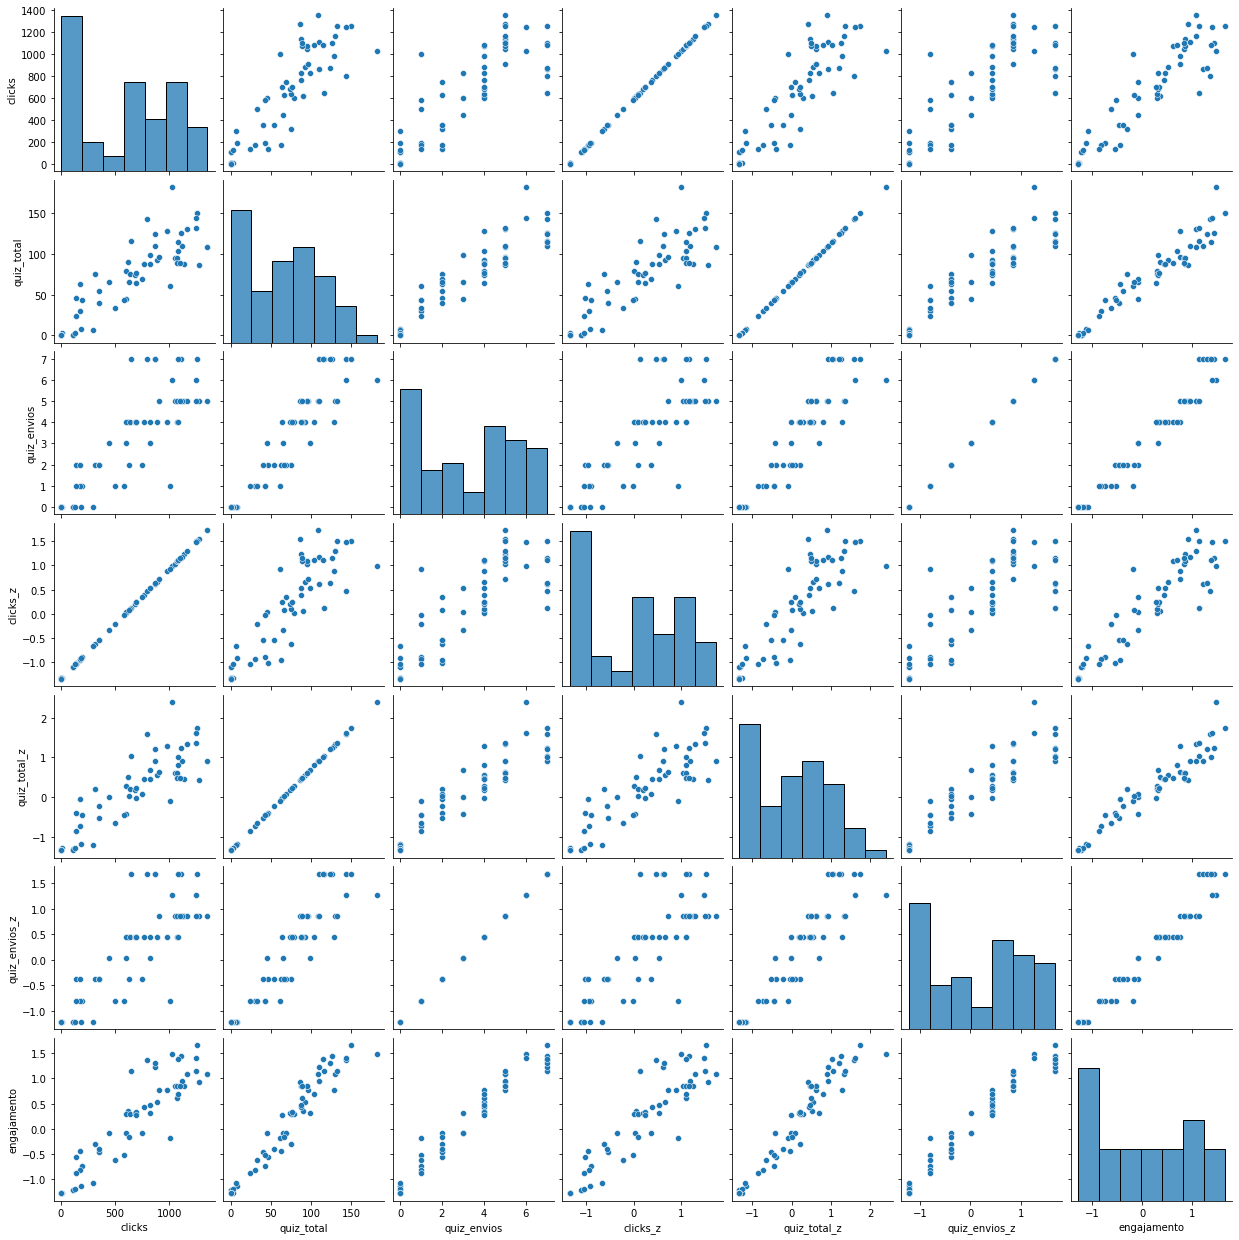

In [19]:
sns.pairplot(indicadores)

## Criar outros indicadores
A lógica acima, de filtrar os logs por algum critério (component = quiz, por exemplo) e depois separar por userid, pode ser implementado de outra forma. Abaixo crio funções que retornam o número de linhas no logs baseado em determinados critérios. Depois posso usar groupby('userid').apply(função) para criar um Series.

Mas, não sei se isso é uma boa maneira de prosseguir: parece que o sistema está sofrendo para calcular os indicadores assim. Não sei ainda se está tendo dificuldes mesmo por causa da ineficiência ou se há algum outro problema no servidor. 

*update*: reiniciei o servidor, parece que era problema do servidor mesmo, não da ineficiência deste método

In [22]:
def nclicks(logs):
    'returns number of clicks'
    return len(logs)

def nviews(logs):
    v = logs.query("action == 'viewed'")
    return len(v)

def nactions(logs,actions = [],components = []):
    'returns number of logs, filtered by actions and components'
    if not actions:
        actions = logs['action'].unique()
    if not components:
        components = logs['component'].unique()
    return len(logs.query("action in @actions & component in @components"))

def fez_questionario(logs):
    return nactions(logs,actions = ['submitted'],components = ['mod_quiz'])
   

In [23]:
indicador_novo1 = logs_f.groupby('userid').apply(nclicks)
# mesma coisa que clicks_por_userid
indicadores['novo1'] = indicador_novo1

indicador_novo2 = logs_f.groupby('userid').apply(nviews)
# filtra por action = viewed
indicadores['novo2'] = indicador_novo2


indicador_novo3 = logs_f.groupby('userid').apply(nactions,actions=['viewed'])
# mesma coisa que novo indicador2, usando uma função mais geral, nactions, 
# com argumentos uma lista de actions e components
indicadores['novo3'] = indicador_novo3

indicador_novo4 = logs_f.groupby('userid').apply(nactions,actions=['viewed'],
                                                 components=['mod_quiz','mod_assign'])
# views de quiz e tarefa
indicadores['novo4'] = indicador_novo4


indicadores

,clicks,quiz_total,quiz_envios,clicks_z,quiz_total_z,quiz_envios_z,engajamento,novo1,novo2,novo3,novo4
userid,,,,,,,,,,,
1170,315,75.0,2.0,-0.628427,0.203471,-0.389089,-0.300784,315,220,220,69
2471,194,43.0,1.0,-0.902768,-0.451732,-0.804118,-0.740684,194,164,164,36
3021,617,90.0,4.0,0.056292,0.510598,0.440968,0.362206,617,472,472,107
3596,1029,182.0,6.0,0.990413,2.394306,1.271025,1.481692,1029,819,819,191
4928,139,46.0,2.0,-1.027469,-0.390306,-0.389089,-0.548988,139,108,108,37
...,...,...,...,...,...,...,...,...,...,...,...
276251,1100,89.0,5.0,1.151390,0.490122,0.855997,0.838376,1100,893,893,148
288579,1,0.0,0.0,-1.340354,-1.332161,-1.219147,-1.277702,1,1,1,0
295092,3,0.0,0.0,-1.335819,-1.332161,-1.219147,-1.276568,3,3,3,0


In [49]:
logs_f['action'].unique()

array(['viewed', 'downloaded', 'uploaded', 'created', 'submitted',
       'added', 'updated', 'accepted', 'started', 'graded', 'reviewed',
       'student', 'left', 'deleted', 'joined', 'ended', 'removed',
       'unassigned', 'completed', 'reassessed', 'assessed', 'sent',
       'shown'], dtype=object)

In [48]:
logs_f.groupby('userid').apply(nactions,actions=['viewed'])

userid
1170      220
2471      164
3021      472
3596      819
4928      108
         ... 
276251    893
288579      1
295092      3
307871      1
307966    421
Length: 64, dtype: int64

In [37]:
logs_f.groupby('userid').apply(nclicks)

userid
1170       315
2471       194
3021       617
3596      1029
4928       139
          ... 
276251    1100
288579       1
295092       3
307871       1
307966     497
Length: 64, dtype: int64

In [47]:
fez_questionario(logs)

200

In [76]:
views = logs.groupby('userid').apply(nviews)
subquizs = logs.groupby('userid').apply(fez_questionario)
views*subquizs

userid
-1            0
 0            0
 2           96
 6            0
 1170       440
           ... 
 276251    4465
 288579       0
 295092       0
 307871       0
 307966     421
Length: 68, dtype: int64

In [51]:
logs.groupby('userid').apply(fez_questionario)

userid
-1          0
 0          0
 2         12
 6          0
 1170       2
           ..
 276251     5
 288579     0
 295092     0
 307871     0
 307966     1
Length: 68, dtype: int64